Tuning opportunities
1. Configuration-Based Hyperparameter Tuning
2. Enhanced Data Augmentation
3. Improved Model Architecture
4. Advanced Callbacks
5. Transfer Learning (Often Best Results)
6. Class Imbalance Handling
7. Ensemble Methods
8. Systematic Tuning Strategy

Quick Start Guide:
For best results immediately: Set "backbone": "mobilenet" and "fine_tune": True
For faster training: Set "backbone": "custom_cnn" and "aug_level": "light"
For maximum accuracy: Enable ensemble with "use_ensemble": True
For experimentation: Uncomment Cell 17 to run systematic tuning

In [1]:
# =======================================================================
# Facial Emotion Recognition - Enhanced with 8 Tuning Improvements
# =======================================================================

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
    GlobalAveragePooling2D, Conv2D, 
    BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
    ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

print("✅ All libraries imported successfully")

2025-11-09 23:43:59.369169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762731839.606121      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762731839.678555      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
Python executable: /usr/bin/python3
✅ All libraries imported successfully


In [2]:
# =======================================================================
# Environment Detection
# =======================================================================

def is_on_kaggle():
    """Detect if running on Kaggle."""
    return os.path.exists('/kaggle/input')

def get_data_path():
    """Detect environment and return appropriate data path."""
    if is_on_kaggle():
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        print("💻 Running on local machine")
        folder_path = "data/images/"
    
    return folder_path

folder_path = get_data_path()
print(f"Data folder path: {folder_path}")

🌐 Running on Kaggle
Data folder path: /kaggle/input/face-expression-recognition-dataset/images


In [3]:
# =======================================================================
# Enhanced Configuration with Tuning Options
# =======================================================================

cfg = {
    # Model Architecture
    "backbone": "custom_cnn",  # Options: "custom_cnn", "mobilenet", "efficientnet"
    
    # Image Parameters
    "picture_size": 48,  # Try: 64, 96 for more detail
    "color_mode": "grayscale",  # "grayscale" or "rgb" (rgb required for transfer learning)
    
    # Training Parameters
    "batch_size": 64,  # Reduced from 128 for better gradient estimates
    "epochs": 30,  # Increased from 30
    "learning_rate": 0.0001,  # Adjusted learning rate
    "dropout_rate": 0.25,  # Increased from 0.25
     
    # Dense layers
    "dense_units": [256,128],
    #"dense_units": [512],
    
    # Data Augmentation (Improvement #2)
    "aug_level": "light",  # Options: "none", "light", "strong", "aggressive"
    
    # Advanced Training
    "precision": "mixed",  # "float32" or "mixed"
    "fine_tune": False,  # Enable fine-tuning for transfer learning
    "fine_tune_epochs": 0,
    
    # Optimizer
    "optimizer": "adam",  # Options: "adam", "adamw", "sgd"
    "weight_decay": 1e-4,  # For AdamW
    
    # Learning Rate Schedule
    "use_lr_schedule": True,  # Cosine annealing (Improvement #5)
    
    # Class Weights (Improvement #3)
    "use_class_weights": True,
    
    # Ensemble (Improvement #7)
    "use_ensemble": False,  # Set True to train multiple models
    "n_ensemble_models": 3,
    
    # Model Parameters
    "no_of_classes": 7,
}

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

# Extract commonly used values
picture_size = cfg["picture_size"]
batch_size = cfg["batch_size"]
epochs = cfg["epochs"]
learning_rate = cfg["learning_rate"]
no_of_classes = cfg["no_of_classes"]
dropout_rate = cfg["dropout_rate"]
dense_units = cfg["dense_units"]

Configuration loaded:
  backbone: custom_cnn
  picture_size: 48
  color_mode: grayscale
  batch_size: 64
  epochs: 30
  learning_rate: 0.0001
  dropout_rate: 0.25
  dense_units: [256, 128]
  aug_level: light
  precision: mixed
  fine_tune: False
  fine_tune_epochs: 0
  optimizer: adam
  weight_decay: 0.0001
  use_lr_schedule: True
  use_class_weights: True
  use_ensemble: False
  n_ensemble_models: 3
  no_of_classes: 7


In [4]:
# =======================================================================
# Mixed Precision Training
# =======================================================================

from tensorflow.keras import mixed_precision

if cfg.get("precision", "float32") == "mixed":
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision training enabled - expect 2-3x speedup!")
else:
    mixed_precision.set_global_policy('float32')
    print("Using float32 precision")

✅ Mixed precision training enabled - expect 2-3x speedup!


In [5]:
# =======================================================================
# Enhanced Data Augmentation
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    
    "light": dict(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True
    ),
    
    "strong": dict(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        fill_mode='nearest'
    ),
    
    "aggressive": dict(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        channel_shift_range=0.2,
        fill_mode='nearest'
    )
}

# Create data generators
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])
datagen_validation = ImageDataGenerator(rescale=1./255)

print(f"✅ Using '{cfg['aug_level']}' augmentation level")

✅ Using 'light' augmentation level


In [6]:
# =======================================================================
# Load Training and Validation Data
# =======================================================================

# Determine color mode
color_mode = cfg["color_mode"]

# Create training set
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

# Create validation set
validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

print(f"\n✅ Data loaded successfully")
print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.

✅ Data loaded successfully
Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
# =======================================================================
# Calculate Class Weights for Imbalanced Data
# =======================================================================

class_weight_dict = None

if cfg.get("use_class_weights", False):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_set.classes),
        y=train_set.classes
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print("\n✅ Class weights calculated:")
    for emotion, weight in zip(class_labels, class_weights):
        print(f"  {emotion:>10}: {weight:.3f}")
else:
    print("\n⚠️  Class weights disabled")


✅ Class weights calculated:
       Angry: 1.031
     Disgust: 9.443
        Fear: 1.003
       Happy: 0.575
     Neutral: 0.826
         Sad: 0.834
    Surprise: 1.285


In [13]:
# =======================================================================
# Enhanced Model Building Functions
# =======================================================================


def build_improved_cnn(cfg):
    """Enhanced CNN with better architecture."""
    
    
    #color_mode = cfg.get("color_mode", "grayscale")
    channels = 1 if color_mode == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)
    
    model = Sequential()
    
    # Block 1 - Double Conv
    model.add(Conv2D(filters=64, 
                      kernel_size=(3, 3), 
                      padding='same', 
                    input_shape=input_shape,
                      name='conv2d_1'))
    model.add(BatchNormalization(name='bn_1'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))
    model.add(Dropout(dropout_rate,name='dropout_1'))
    
    
    # Block 2 - Double Conv
    model.add(Conv2D(filters=128, 
                      kernel_size=(5, 5), 
                      padding='same',
                      name='conv2d_2'))
    model.add(BatchNormalization(name='bn_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
    model.add(Dropout(dropout_rate,name='dropout_2'))
    
    # Block 3 - Double Conv
    model.add(Conv2D(filters=256, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_3'))
    model.add(BatchNormalization(name='bn_3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_3'))
    model.add(Dropout(dropout_rate,name='dropout_3'))
    
    # Block 4 - Double Conv
    model.add(Conv2D(filters=256, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_4'))
    model.add(BatchNormalization(name='bn_4'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_4'))
    model.add(Dropout(dropout_rate,name='dropout_4'))

    
    # Block 5 - Double Conv
    model.add(Conv2D(filters=256, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_5'))
    model.add(BatchNormalization(name='bn_5'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_5'))
    model.add(Dropout(dropout_rate,name='dropout_5'))
    
    
        # Output layer
    # Add dense layers before output
    model.add(Flatten())
    for idx, units in enumerate(cfg["dense_units"]):
        model.add(Dense(units, name=f"dense_{idx+1}"))
        model.add(BatchNormalization(name=f"bn_dense_{idx+1}"))
        model.add(Activation('relu', name=f"act_dense_{idx+1}"))
        model.add(Dropout(dropout_rate, name=f"dropout_dense_{idx+1}"))
    model.add(Dense(no_of_classes, activation='softmax', dtype='float32', name='output_layer'))

   
    # Compile with optimizer choice
    optimizer_name = cfg.get("optimizer", "adam")
    if optimizer_name == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=cfg.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    
    return model, None

# Build model based on configuration
print(f"\n{'='*70}")
print(f"Building model with '{cfg['backbone']}' backbone...")
print(f"{'='*70}")

if cfg["backbone"] == "custom_cnn":
     model, base_model = build_improved_cnn(cfg)
else:
    print ("removed mobilenet and efficientnet model code")

print(f"\n✅ Model built successfully")
model.summary()


Building model with 'custom_cnn' backbone...

✅ Model built successfully


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 6, 6, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 3, 3, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_5 (MaxPooling2D)      │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             

 Total params: 1,785,863 (6.81 MB)

 Trainable params: 1,783,175 (6.80 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [14]:
# =======================================================================
# Advanced Training Callbacks
# =======================================================================

# Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping with more patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased from 10
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Increased from 5
    min_lr=0.0001,
    verbose=1
)

# Cosine annealing schedule (Improvement #5)
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate schedule."""
    import math
    epochs = cfg.get("epochs", 50)
    initial_lr = cfg.get("learning_rate", 1e-4)
    min_lr = 1e-7
    
    if epoch < 5:  # Warmup phase
        return initial_lr * (epoch + 1) / 5
    else:
        progress = (epoch - 5) / (epochs - 5)
        return min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

callbacks_list = [checkpoint, early_stopping, reduce_lr]

if cfg.get("use_lr_schedule", False):
    lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=1)
    callbacks_list.append(lr_scheduler)
    print("✅ Using cosine annealing learning rate schedule")
else:
    callbacks_list.append(reduce_lr)
    print("✅ Using ReduceLROnPlateau")

print(f"✅ Callbacks configured: {len(callbacks_list)} callbacks")

✅ Using cosine annealing learning rate schedule
✅ Callbacks configured: 4 callbacks


In [15]:
# =======================================================================
# Model Training
# =======================================================================

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Augmentation: {cfg['aug_level']}")
print(f"Backbone: {cfg['backbone']}")
print(f"Class weights: {'Enabled' if class_weight_dict else 'Disabled'}")
print("="*70)

history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=validation_set,
    validation_steps=validation_set.n // validation_set.batch_size,
    callbacks=callbacks_list,
    class_weight=class_weight_dict,  # Improvement #3
    verbose=1
)

print("\n✅ Initial training complete!")


🚀 STARTING TRAINING
Target: 30 epochs with early stopping
Batch size: 64
Learning rate: 0.0001
Augmentation: light
Backbone: custom_cnn
Class weights: Enabled


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30


I0000 00:00:1762732679.735840     106 service.cc:148] XLA service 0x7ef318007db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762732679.737142     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762732679.737163     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762732680.751405     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/450 ━━━━━━━━━━━━━━━━━━━━ 2:18:26 18s/step - accuracy: 0.1719 - loss: 2.3208

I0000 00:00:1762732692.361269     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.1623 - loss: 2.4492
Epoch 1: val_accuracy improved from -inf to 0.13352, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 276s 573ms/step - accuracy: 0.1623 - loss: 2.4491 - val_accuracy: 0.1335 - val_loss: 2.2942 - learning_rate: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/30
  1/450 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1875 - loss: 2.2675

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.13352
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1875 - loss: 2.2675 - val_accuracy: 0.1334 - val_loss: 2.2936 - learning_rate: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.000000000000001e-05.
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1614 - loss: 2.2693
Epoch 3: val_accuracy did not improve from 0.13352
450/450 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - accuracy: 0.1614 - loss: 2.2692 - val_accuracy: 0.0774 - val_loss: 2.0756 - learning_rate: 6.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 8e-05.
Epoch 4/30
  1/450 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1719 - loss: 1.7220
Epoch 4: val_accuracy did not improve from 0.13352
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1719 - loss: 1.7220 - val_accuracy: 0.0768 - val_loss: 2.0768 - learning_rate: 8.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/30
450/450 ━━━━

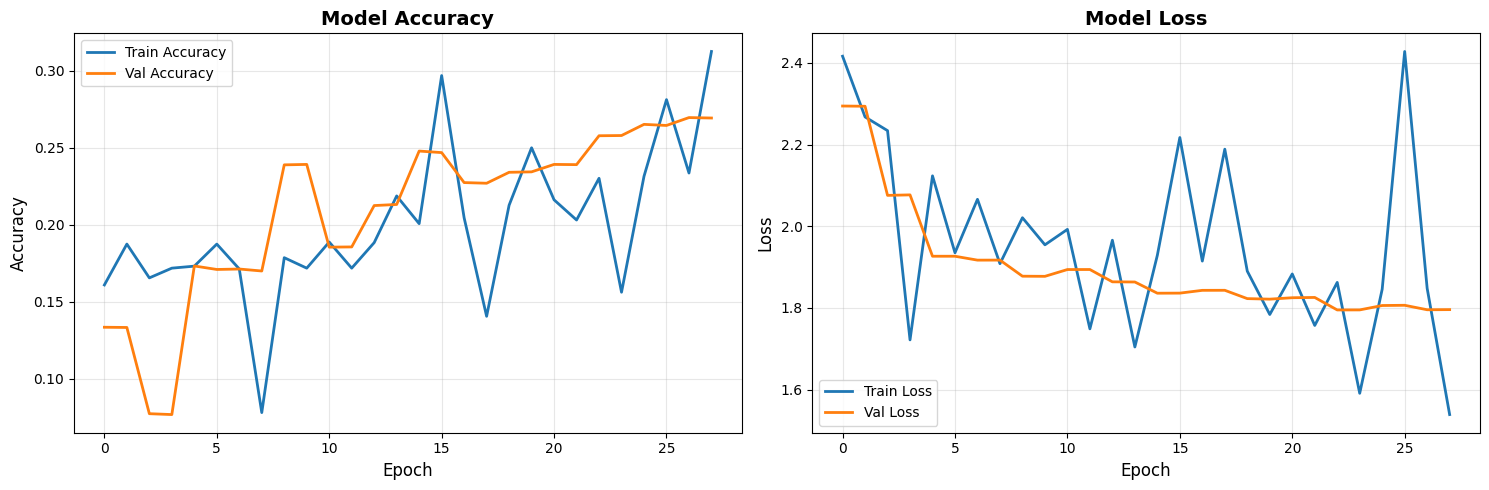


📊 FINAL EVALUATION
Training Accuracy:   0.2467 (24.67%)
Validation Accuracy: 0.2594 (25.94%)
Training Loss:       1.8511
Validation Loss:     1.7934


In [22]:
# =======================================================================
# Training History Visualization
# =======================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final evaluation
print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70)
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*70)

In [17]:
# =======================================================================
# Detailed Performance Analysis
# =======================================================================

from keras.models import load_model

# Load best model
my_model = load_model('best_model.keras', compile=False)

# Get predictions
print("Generating predictions on validation set...")
validation_set.reset()
predictions = my_model.predict(validation_set, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_set.classes

# Calculate metrics
accuracy = np.mean(predicted_classes == true_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(f"\n✅ Best Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step

✅ Best Model Accuracy: 0.2712 (27.12%)


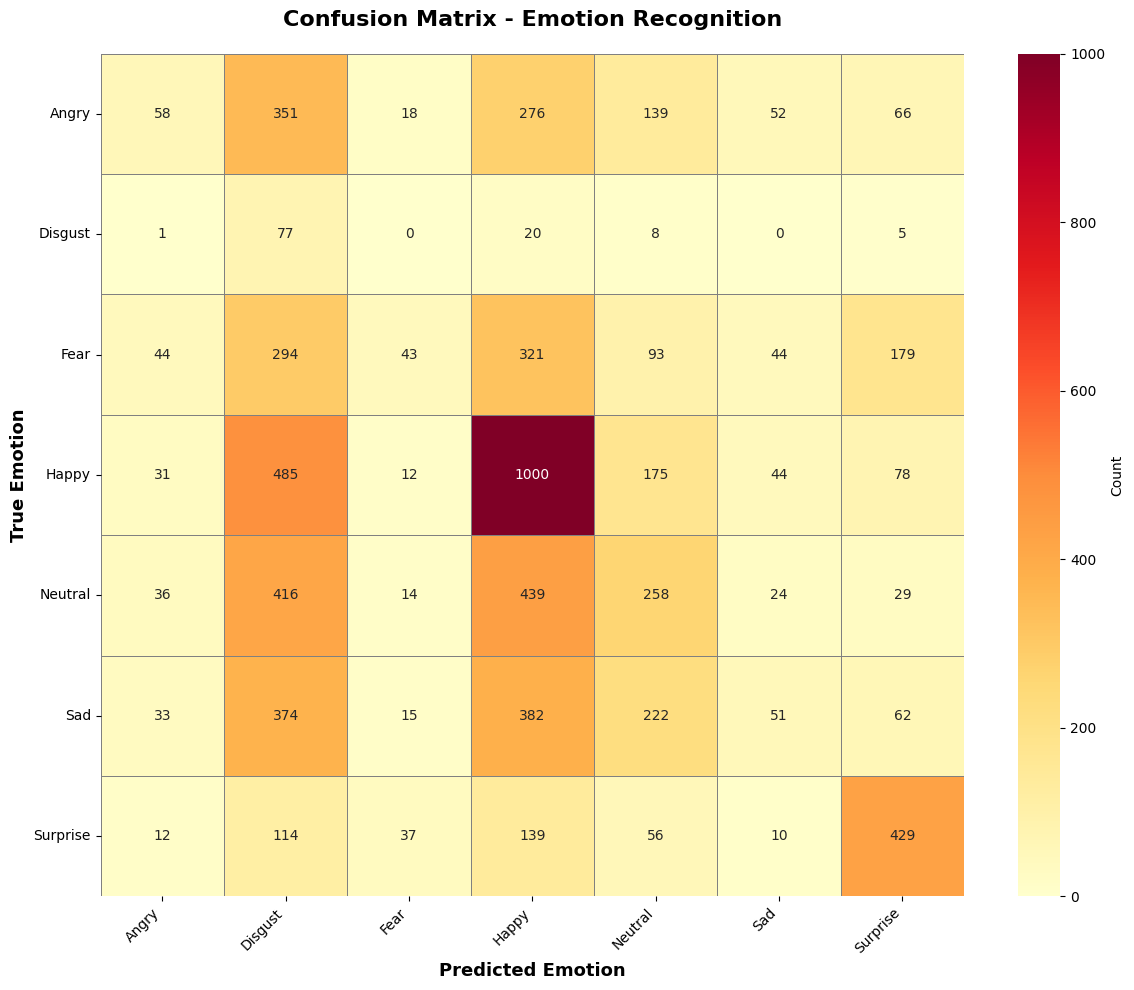

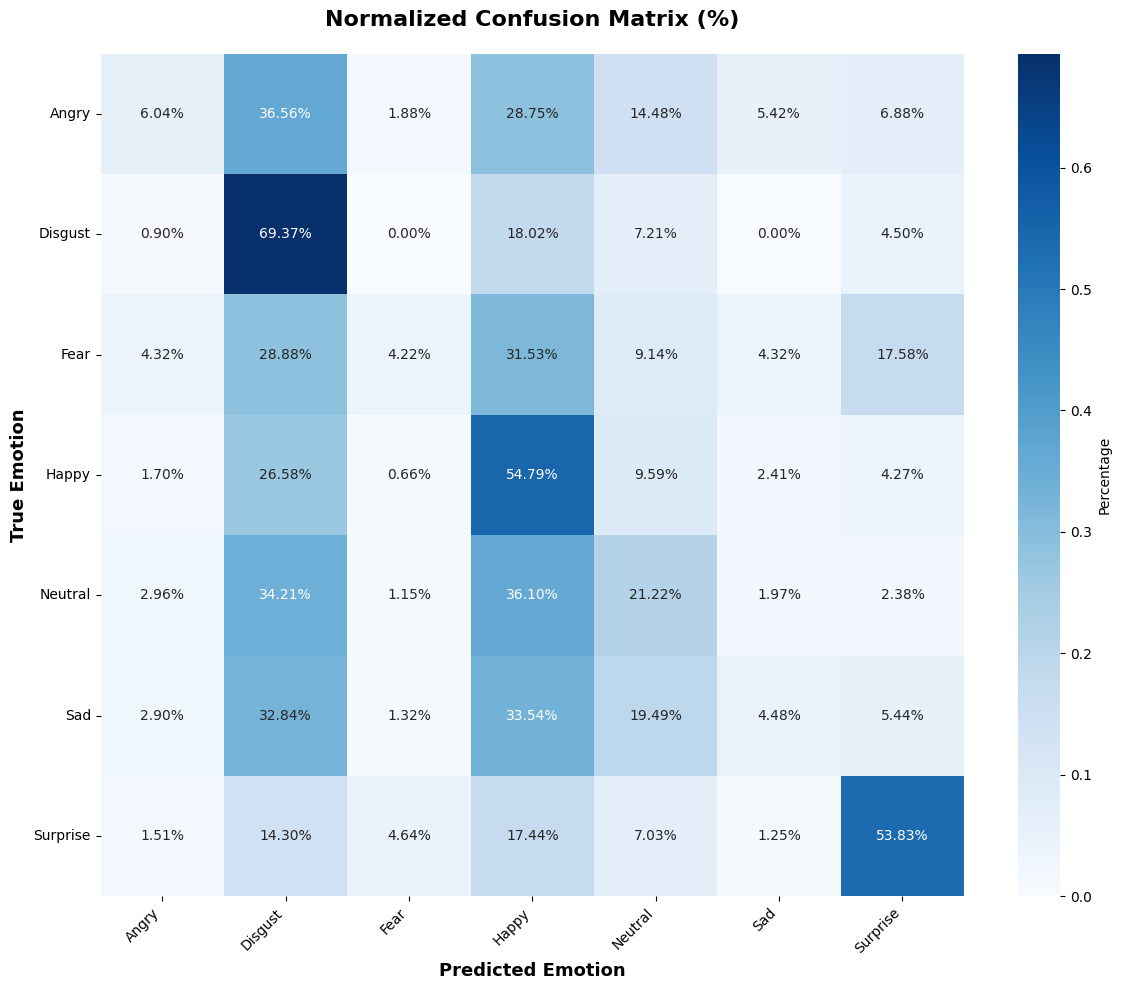


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry     0.2698    0.0604    0.0987       960
     Disgust     0.0365    0.6937    0.0693       111
        Fear     0.3094    0.0422    0.0743      1018
       Happy     0.3880    0.5479    0.4543      1825
     Neutral     0.2713    0.2122    0.2381      1216
         Sad     0.2267    0.0448    0.0748      1139
    Surprise     0.5059    0.5383    0.5216       797

    accuracy                         0.2712      7066
   macro avg     0.2868    0.3056    0.2187      7066
weighted avg     0.3223    0.2712    0.2544      7066



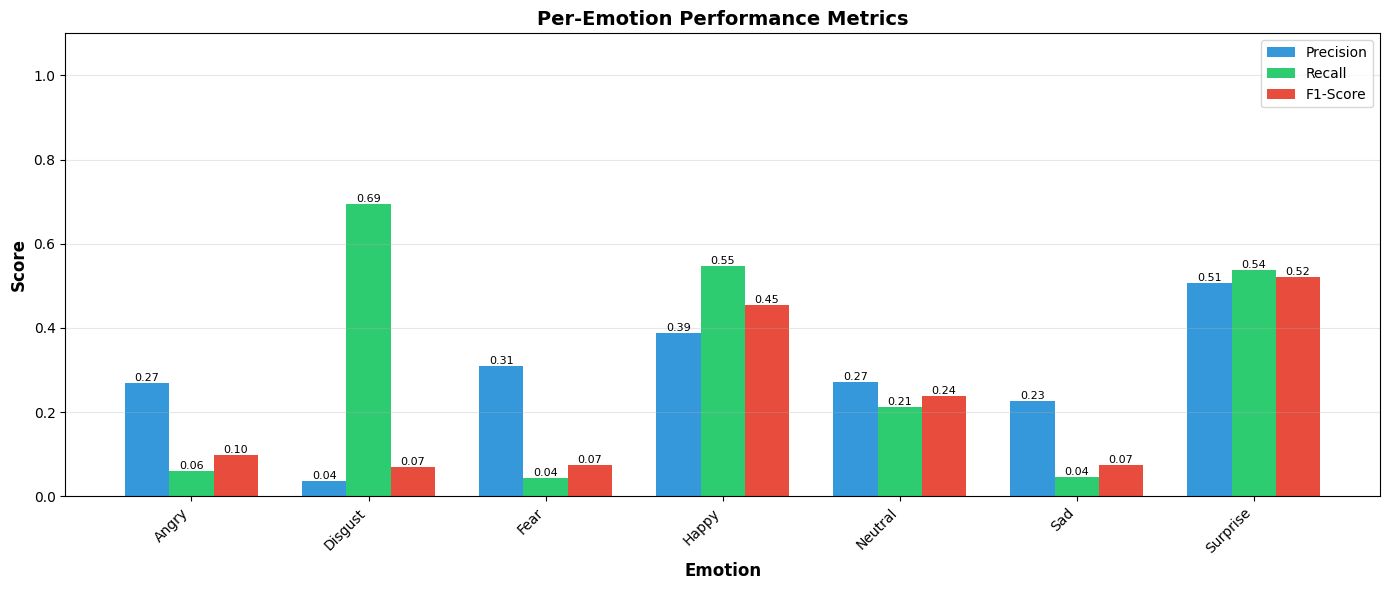


📊 PERFORMANCE SUMMARY TABLE
 Emotion Precision Recall F1-Score  Support
   Angry    26.98%  6.04%    9.87%      960
 Disgust     3.65% 69.37%    6.93%      111
    Fear    30.94%  4.22%    7.43%     1018
   Happy    38.80% 54.79%   45.43%     1825
 Neutral    27.13% 21.22%   23.81%     1216
     Sad    22.67%  4.48%    7.48%     1139
Surprise    50.59% 53.83%   52.16%      797

⚠️  TOP 5 MISCLASSIFICATION PAIRS
     Happy → Disgust    :  485 times
   Neutral → Happy      :  439 times
   Neutral → Disgust    :  416 times
       Sad → Happy      :  382 times
       Sad → Disgust    :  374 times


In [18]:
# =======================================================================
# Enhanced Performance Visualizations
# =======================================================================

# 1. Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Emotion Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_classes, predicted_classes, 
                           target_names=class_labels,
                           digits=4))

# 4. Per-Class Metrics Bar Chart
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(7)
)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_labels))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Emotion Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary Table
summary_df = pd.DataFrame({
    'Emotion': class_labels,
    'Precision': [f'{p:.2%}' for p in precision],
    'Recall': [f'{r:.2%}' for r in recall],
    'F1-Score': [f'{f:.2%}' for f in f1],
    'Support': support.astype(int)
})

print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# 6. Misclassification Analysis
misclassified = cm.copy()
np.fill_diagonal(misclassified, 0)

top_confusions = []
for i in range(7):
    for j in range(7):
        if i != j:
            top_confusions.append((class_labels[i], class_labels[j], misclassified[i, j]))

top_confusions.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*70)
print("⚠️  TOP 5 MISCLASSIFICATION PAIRS")
print("="*70)
for true_label, pred_label, count in top_confusions[:5]:
    print(f"{true_label:>10} → {pred_label:<10} : {count:>4} times")
print("="*70)

In [19]:
# =======================================================================
# Save Model with Timestamp
# =======================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"emotion_recognition_{timestamp}.keras"

if is_on_kaggle():
    output_path = "/kaggle/working/"+timestamp+"/"
else:
    output_path = "outputs/"+timestamp+"/"
    
os.makedirs(output_path, exist_ok=True)
full_path = Path(output_path) / model_name
model.save(str(full_path))

print(f"\n💾 Model saved: {full_path}")
print(f"📊 Final Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")


💾 Model saved: /kaggle/working/20251110_001518/emotion_recognition_20251110_001518.keras
📊 Final Validation Accuracy: 0.2594 (25.94%)


In [20]:
# =======================================================================
# Ensemble Training (Optional)
# =======================================================================

if cfg.get("use_ensemble", False):
    print("\n" + "="*70)
    print("🎯 TRAINING ENSEMBLE MODELS")
    print("="*70)
    
    n_models = cfg.get("n_ensemble_models", 3)
    ensemble_models = []
    
    for i in range(n_models):
        print(f"\n{'='*70}")
        print(f"Training Ensemble Model {i+1}/{n_models}")
        print(f"{'='*70}")
        
        # Vary hyperparameters slightly
        cfg_copy = cfg.copy()
        cfg_copy["learning_rate"] = cfg["learning_rate"] * (0.8 + 0.4 * np.random.random())
        cfg_copy["dropout_rate"] = 0.3 + 0.2 * np.random.random()
        
        # Build model
        if cfg["backbone"] in ["mobilenet", "efficientnet"]:
            ensemble_model, _ = build_transfer_learning_model(cfg_copy)
        else:
            ensemble_model, _ = build_improved_cnn(cfg_copy)
        
        # Train
        history_ens = ensemble_model.fit(
            train_set,
            validation_data=validation_set,
            epochs=30,
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )
        
        ensemble_models.append(ensemble_model)
        
        # Save
        ensemble_model.save(f"ensemble_model_{i+1}.keras")
    
    # Ensemble prediction
    print("\n" + "="*70)
    print("🎯 ENSEMBLE PREDICTION")
    print("="*70)
    
    validation_set.reset()
    ensemble_predictions = []
    
    for i, ens_model in enumerate(ensemble_models):
        print(f"Getting predictions from model {i+1}...")
        pred = ens_model.predict(validation_set, verbose=0)
        ensemble_predictions.append(pred)
    
    # Average predictions
    avg_predictions = np.mean(ensemble_predictions, axis=0)
    ensemble_predicted_classes = np.argmax(avg_predictions, axis=1)
    
    # Evaluate ensemble
    ensemble_accuracy = np.mean(ensemble_predicted_classes == true_classes)
    
    print(f"\n✅ Ensemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
    print(f"📈 Improvement over single model: {(ensemble_accuracy - accuracy)*100:.2f}%")
else:
    print("\n⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)")


⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)


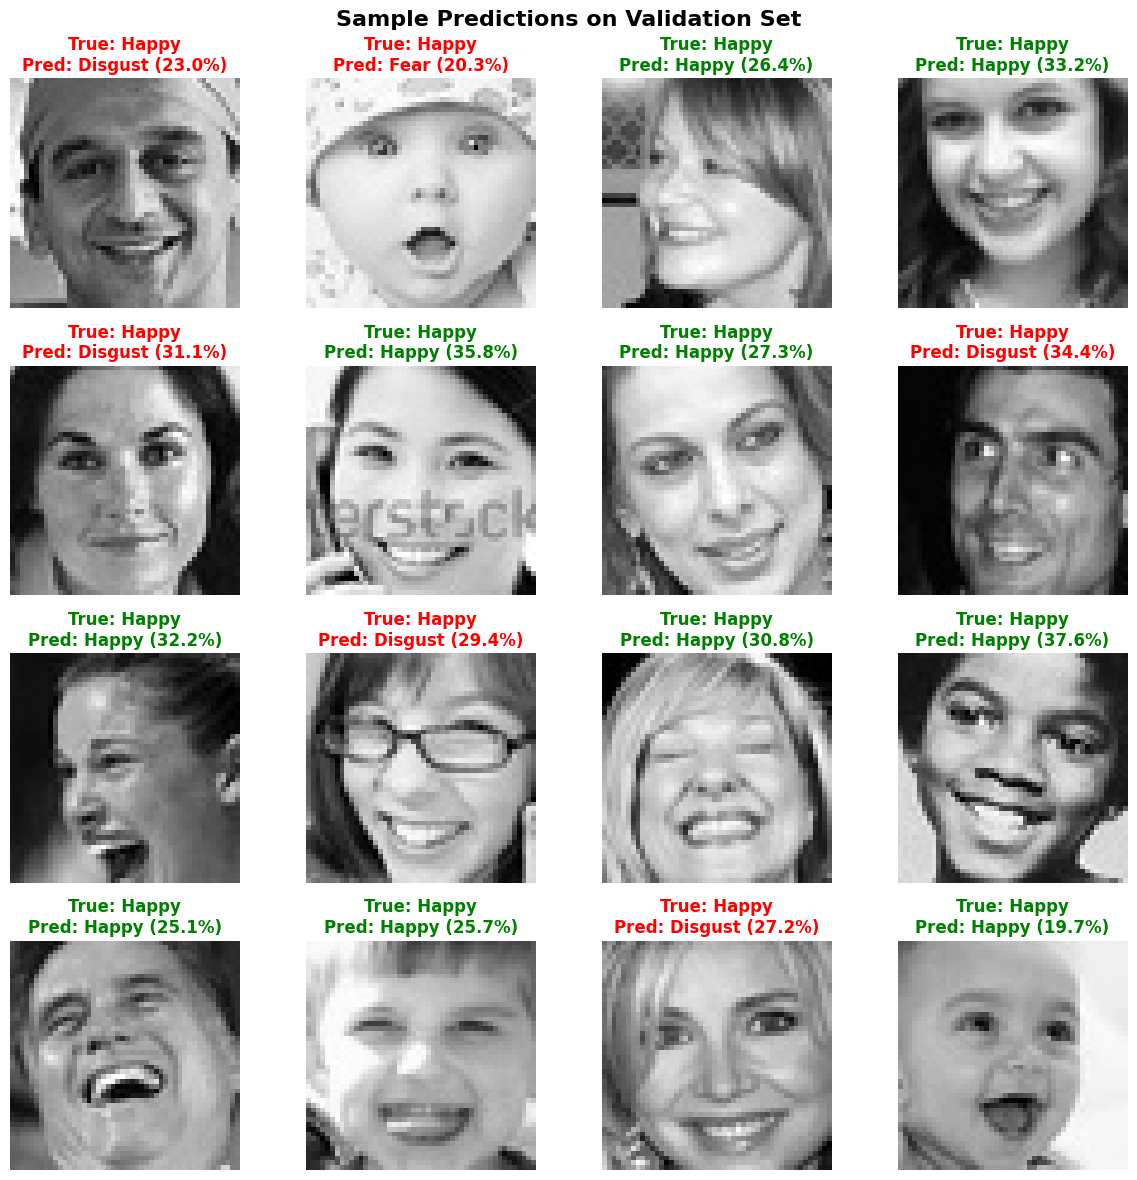

In [21]:
# =======================================================================
# Sample Predictions Visualization
# =======================================================================
import random

# Get a random batch from validation set
random_batch_idx = random.randint(0, len(validation_set) - 1)
sample_images, sample_labels = validation_set[random_batch_idx]

# Predict
sample_preds = my_model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Randomly select 16 indices from the batch
num_samples = min(16, len(sample_images))
random_indices = random.sample(range(len(sample_images)), num_samples)

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
    
    true_label = class_labels[sample_true_classes[idx]]
    pred_label = class_labels[sample_pred_classes[idx]]
    confidence = sample_preds[idx][sample_pred_classes[idx]] * 100

    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[idx] == sample_pred_classes[idx] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()